## This is an example about how to proceed Factorial Analysis, following Principal Component Analysis (PCA) methodology, using Python, Pandas, NumPy, SciPy, Scikit-learn, Factor-Analyzer, Sympy, Pingouin, PyShp, Matplotlib, Seaborn and Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import matplotlib.ticker as mtick
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import seaborn as sns
import scipy as sp
import sympy as sy
import pingouin as pg
import os
import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Student Disciplines' Grades. And a General Overview about Factorial Analysis by Principal Components.

In this sample use case, we have some students' grades regarding four disciplines (features, variables). Instead of clustering analysis, where we directly join similar observations (students) into similar groups (clusters) based on the original features, we now want to do a factorial analysis, using PCA (Principal Component Analysis), in order to join all features (disciplines) into orthogonal (fewer) components (axes) — two or three at most — with different specific weights of each discipline represented in each component, and different factorial scores of each observation on those new axes, in order to maximize the variance (of factorial scores), that is, the magnitude of representation of the original observations in the new components, discarding the least representative ones.

The two or three components will contain most of the representation of the original observations, even if we had tens of variables (dimensions) at first. The correlation of representation of each original variable in each component is called loadings, and the loss of each original variable in the components, after we discard the least representative ones, is called communalities.

All this is done so that we can ultimately reduce the observations’ dimensionality to fewer dimensions (axes) and, instead of four disciplines (features, variables), as originally in this case, have maybe only two components (axes) to analyze the data with (including most of the original variables and data in them).

We can then rank the observations based on a weighted sum of factorial scores and relative variance of each component, perform a clustering analysis based on fewer dimensions, or even do a regression analysis with better predictivity, if that is the case.

So, the main utilities of such a machine learning technique are: dimensionality (features, variables) reduction, summarization, revealing of hidden constructs or latent dimensions (difficult to perceive in the original variables), handling of multicollinearity into orthogonal independent components (useful for regression, clustering, etc.), better visualization and analysis of the data — especially when you have lots of original variables — ranking and scoring of the observations, data cleaning (discarding noise and keeping signal), and feature engineering improvements when training machine learning models (faster training, less overfitting, better generalization).

The data used in each phase of the method below is always the standardized Z-score data, calculated internally at each step. For such data, we have a Pearson correlation matrix, on which a determinant calculation is applied and, from its extracted polynomial equation, we obtain the roots, which in turn are the eigenvalues of the correlation matrix and represent the absolute variance intrinsic to each component (measurement of how spread out the projected values - scores - are at each eigen axis).

The sum of the eigenvalues equals the number of original variables, so the relative variance is the absolute eigenvalue explained by each respective component divided by the total absolute variance (the number of original variables).

In addition to the variances of each component, we also have the eigenvector values (coefficients) of each component (for each original variable), which contain the weights of each original variable in each component. The loadings, which are the correlations of each variable with each component, are the product of the weight (coefficient) of each original variable (eigenvector values) and the square root of the absolute variance (eigenvalue) explained by each component.

The sum of squares of the loadings of all variables for a component is the communality of that component. The first one or two components (three, at most) should have the highest possible loadings (and explained variance - eigenvalue), and thus the least loss of information (highest communalities) for each original variable represented in those components.

Thus, no matter how many variables we had originally, we can now visualize, analyze, and manipulate the data using only the main components (dimensions) obtained through this method.

The eigenvector weights (coefficients) of each original variable in each component, in turn, give an understanding of which variables are most represented in each component - all original variables are represented in all components, but with different proportions, some more, others less. Meanwhile, the factorial (or component) scores for each observation — obtained when the Z-score values are applied to each component equation and multiplied by the weights of each variable — give us the relative position of those observations when distributed through each component axis.

Here, variance (of factorial scores) means representativeness of data (at that eigen axis), while weights, loadings and communalities represent the statistical correlation of original features (variables) with the components. This kind of analysis does not measure or consider the real-world importance of any feature. The components, in turn, are derived features, that don't even exist in reality - they're abstract constructs, based on latent semantics combined with the semantics already present at the original features.

For understanding PCA when performing factorial analysis, you should look for specific references that explain it better, with lots of graphs and animations, which is not the purpose of this Python notebook. Here, we simply aim to demonstrate how to apply the technique using Python-specific libraries, which, thankfully, avoids the need to perform extensive matrix and vector calculations, including solving high-degree polynomial equations (when finding the eigenvalues, eigenvectors and the other properties mentioned above).

In [2]:
# reading and displaying our dataset
grades = pd.read_excel("grades_factorial.xlsx")
grades

,STUDENT,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
0,Gabriela,5.8,4.0,1.0,6.0
1,Luiz Felipe,3.1,3.0,10.0,2.0
2,Patrícia,3.1,4.0,4.0,4.0
3,Gustavo,10.0,8.0,8.0,8.0
4,Letícia,3.4,2.0,3.2,3.2
...,...,...,...,...,...
95,Sheila,7.7,4.3,5.2,5.1
96,Pedro,9.0,6.0,4.0,9.8
97,Horácio,9.3,6.0,7.0,7.0
98,Leandro,9.0,6.5,3.0,9.0


In [3]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STUDENT     100 non-null    object 
 1   FINANCE     100 non-null    float64
 2   ACCOUNTING  100 non-null    float64
 3   MARKETING   100 non-null    float64
 4   ACTUARIAL   100 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.0+ KB


In [4]:
grades.describe()

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
count,100.000000,100.000000,100.000000,100.000000
mean,5.834000,4.717000,5.668000,5.314000
std,3.122749,2.455999,2.828351,2.513078
min,0.600000,1.900000,1.000000,1.700000
25%,3.100000,2.900000,3.000000,3.200000
50%,5.800000,4.000000,6.000000,5.000000
75%,9.000000,6.000000,8.000000,7.025000
max,10.000000,10.000000,10.000000,10.000000


In [5]:
# selecting only quantitative variables (as cluster analysis, factorial analysis by PCA is only for quantitative data)
# values will be automatically standardized in Z score within each method we'll be using below, for the matricial calculus
# no need to transform into Z values here, only if we were to calculate everything by hand (manually - without python)
grades_without_student = grades[["FINANCE", "ACCOUNTING", "MARKETING", "ACTUARIAL"]]
grades_without_student

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
0,5.8,4.0,1.0,6.0
1,3.1,3.0,10.0,2.0
2,3.1,4.0,4.0,4.0
3,10.0,8.0,8.0,8.0
4,3.4,2.0,3.2,3.2
...,...,...,...,...
95,7.7,4.3,5.2,5.1
96,9.0,6.0,4.0,9.8
97,9.3,6.0,7.0,7.0
98,9.0,6.5,3.0,9.0


In [6]:
# First step is to create a Pearson Correlation Matrix for the relation, two by two, of all variables
# Pearson correlation measures the association between quantitative variables, regarding their values, going from -1 (negative 
# relationship) up until +1 (positive relationship), being 0 the null relationship

![covariance-correlation-coefficient.png](covariance-correlation-coefficient.png)

![pearson-correlation-matrix.png](pearson-correlation-matrix.png)

In [7]:
# one way of creating the Pearson correlation matrix - for this dataset. We can observe high positive relationships between finance 
# and accounting, between finance and actuarial and between accounting and actuarial... except for marketing, that correlates to 
# basically no other discipline
pg.rcorr(grades_without_student, method='pearson', upper='pval', decimals=4, pval_stars={0.01: '***', 0.05: '**', 0.10: '*'})

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
FINANCE,-,***,,***
ACCOUNTING,0.7556,-,,***
MARKETING,-0.0295,0.0029,-,
ACTUARIAL,0.7109,0.8081,-0.0443,-


In [8]:
# another way of creating the Pearson correlation matrix
correlation_matrix = grades_without_student.corr()
correlation_matrix

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
FINANCE,1.000000,0.755550,-0.029531,0.710871
ACCOUNTING,0.755550,1.000000,0.002856,0.808092
MARKETING,-0.029531,0.002856,1.000000,-0.044346
ACTUARIAL,0.710871,0.808092,-0.044346,1.000000


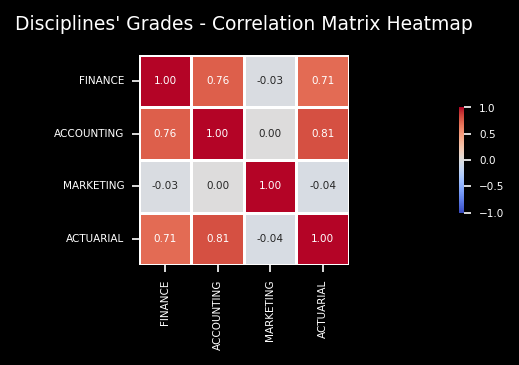

In [9]:
# ploting the correlation matrix above into a heatmap graph
plt.figure(figsize=(15,3), dpi=150)
ax = sns.heatmap(correlation_matrix, 
            cmap=plt.cm.coolwarm,
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=.5,
            annot=True,
            fmt='.2f', 
            annot_kws={'size':5},
            cbar_kws={"shrink":0.50})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=5)
plt.title("Disciplines' Grades - Correlation Matrix Heatmap", fontsize=9, pad=12)
plt.tight_layout()
plt.tick_params(labelsize=5)
plt.show()

In [10]:
# From the correlation matrix above, and by considering the high correlation between some of the variables of our dataset, we can
# already imply that we can join, significantly, some of such variables into a fewer number of components, and have considerably
# high variances explained by the first one or two components... and therefore, a good representation of the data on those. The
# total number of components is always the number of original variables, but the significant components we keep are generally 1-3,
# the most representative ones (with higher variances - eigenvalues), being the others discarded. But, in order to be sure and have
# a measurable proof of that, we calculate the Sphericity of Bartlett Test, as below:

![bartlett.jpg](bartlett.jpg)

In [11]:
# observe that we have a very significant p-value (0.0), much less than 5% or even 1% (which could be our alfa), therefore the 
# hypothesis test of Qui² of Bartlet is significant, the NULL hypothesis is rejected and we can proceed with our component 
# analysis and expect satisfactory results on the analysis. If no original variable had considerably high correlation values 
# (either positive, negative or both), this test would not be significant and we shouldn't proceed with the analysis, 'cause
# we wouldn't succeed in finding significant components representative of our dataset, in order to do any analytics on it. In such
# a case, we should apply other analytics methods, that would not depend on variables' correlation
bartlett, p_value = calculate_bartlett_sphericity(grades_without_student)
print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 191.88
p-valor: 0.0


In [12]:
# Applying the PCA main method for later extract the specific attributes from the output object
# (eigenvalues, eigenvector values, loadings, communalities, etc)
# At first, we set all components, i.e., 4, in order to calculate the eigen statistics. After we have it all calculated, then
# we run this method again, but then only with the 2 principal components, instead of 4... discarding the last two, which would 
# not have much variance left (most of the variance - and data representation - will concentrate on the first 2 components).
fa = FactorAnalyzer(n_factors=4, method='principal', rotation=None).fit(grades_without_student)

In [13]:
# getting the 4 eigenvalues for the 4-variable correlation matrix
# These eigenvalues represent the absolute variance of each component in respect to their observations' factorial scores
# The higher the eigenvalue and variance explained at a component, the most representative that component is regarding the 
# observations spread throughout its axis, what makes that component significant for analysing the dataset (more than any
# original variable isolated, if lambda > 1)
eigenvalues = fa.get_eigenvalues()[0]
print(eigenvalues)

[2.51812681 1.0003793  0.29761585 0.18387804]


In [14]:
# the sum of the eigenvalues, or the total absolute variance, is always the number of the original variables, in this case, 4.
print(round(eigenvalues.sum(), 2))

4.0


In [15]:
# The eigenvalues (lambda) are calculated using the determinant formula below, getting the 4th-grade polynomial equation (in this 
# case) and extracting its 4 roots. The polynomial grade is equal to the number of original variables: for 100 variables, you'd 
# have a 100th-grade polynomial to solve... Based on these, we select the best components, generally the ones with eigenvalues >=1

![eigenvalues.png](eigenvalues.png)

In [16]:
# You can optionally get the polynomial as below (although not needed if you get the eigenvalues directly as above):
# getting instance of lambda sy object
lamda_symbol = sy.symbols('lamda')
sy.init_printing(scale=0.8)

# getting instance of correlation matrix sy object
correlation_matrix_sy = sy.Matrix(correlation_matrix)

# getting the polynomial for that matrix equation
polynomial = correlation_matrix_sy.charpoly(lamda_symbol)

# show the polynomial
polynomial

In [17]:
# getting the roots of the polynomial: the eigenvalues (or autovalues)
# getting also the eigenvector (or autovector) values, for each eigenvalue as well: this vector is the one whose values multiplied 
# by the matrix above give the zero matrix as a result (see formula below)
# While the eigenvalues are the absolute variance of each principal component, the eigenvector values, for each eigenvalue, i.e.,
# for each component, are the weights or the coefficients corresponding to each variable, that multiply the corresponding Z values,
# from each observation, at each component expression, resulting into the factorial score (for each observation, at each component 
# axis). At least in theory. In practice, the eigenvector values are calculated by each lib itself, using regression analysis, and 
# considering all vector adjustments involved... in addition to the correlation matrix itself.
# We had already gotten the eigenvalues as attributes from the fa object above, but below is another way of getting them.
# The eigenvector values, shown below, are from the scipy lib, not from the FactorAnalyzer lib. Each lib calculates them 
# differently, because of different vectorial adjustments. For this projects' purposes, the fa eigenvector values are the ones to 
# be considered, including when calculating the factorial scores (also using the FactorAnalyzer lib).
autovalues, autovectors = sp.linalg.eigh(correlation_matrix)
autovalues = autovalues[::-1]
autovectors = autovectors[:, ::-1]
print(f"autovalues: {autovalues}")
print(f"autovectors: {autovectors}")

autovalues: [2.51812681 1.0003793  0.29761585 0.18387804]
autovectors: [[-5.64257427e-01  7.08433220e-03  8.00525267e-01  2.01798577e-01]
 [-5.88604380e-01  4.85714109e-02 -2.19566828e-01 -7.76515363e-01]
 [ 2.67613167e-02  9.98743203e-01 -6.56858913e-04  4.23723267e-02]
 [-5.78309841e-01 -1.01313321e-02 -5.57628257e-01  5.95403906e-01]]


In [18]:
# As said above, although, theoretically, the weights would be the values of the eigenvectors themselves, in practice, because of 
# optimizations, the weights actually used are derived, but not exactly the eigenvector values. One way, used in some PCA scenarios, 
# is to divide each respective eigenvector value by the square root of the respective eigenvalue. But that is not a general rule. 
# Each lib (e.g. FactorAnalyzer) has its own regression way of calculating the weights, including in it: optimizations, rotations, 
# corrections, etc. These practical computed weights are the ones really used as coefficients at the component expressions, when 
# calculating the factorial scores, for each observation, when using such libraries. In the case of the "principal" method, used 
# above at the fa instantiation, however, the weights won't be calculated as the fa object is instsantiated, but only when calling
# the transform method for getting the factorial scores. This is specific to the FarctorAnalyzer lib. When the weights are finally
# calculated (there should be a direct method for that, but there isn't), i.e., after the transform() method is called, they could 
# be gotten from the fa object and shown, as below. So here, instead of trying to get the weights which would not be available yet, 
# we'll define a function, that should only be called after the transform method has been called for the first time. Then the 
# weights will be available as attributes of the fa object.

# ONLY CALL THIS FUNCTION IF THE TRANSFORM() FA METHOD HAS ALREADY BEEN CALLED, AT LEAST ONCE
def get_weights_df()->pd.DataFrame:
    weights = fa.weights_
    weights_df = pd.DataFrame(weights)
    weights_df.columns = [f"C{i+1} weight" for i, v in enumerate(weights_df.columns)]
    weights_df.index = grades_without_student.columns
    return weights_df

![weights-optimized.png](weights-optimized.png)

![scores.png](scores.png)

In [19]:
# The eigenvector values (v), for each k variable, at each component (axis), can be calculated, theoretically, as below.
# With the weights, either the theoretical ones - directly from the eigenvector values - or the adjusted ones, from regression
# analysis using the lib internal procedures, we can write the expression of each component, having as factors the weights, 
# multiplied by the respective Z values - for each original variable, at each component, for each observation.

# But, before that, we should analyse the eigenvalues and relative variances, along with the loadings and communalities, in order
# to have a notion about what components to keep (and what others to discard) and also to have in mind what original variables are
# represented the most on each component, and what semantics the analysis of data on each specific component will express - the 
# semantics of each component is different from the semantics of each individual original variable. Each component will be a 
# composition of the original variables (altogether, in different proportions), and probably will reflect a combination of 
# original semantics, or even new latent semantics not present on the original variables.

![eigenvectors.png](eigenvectors.png)

In [20]:
# Based on the eigenvalues, we can calculate the relative variance of each component regarding the total variance.
# Observe that, by choosing only the first 2 components (absolute eigenvalue > 1 - Kaiser or latent root criteria), we're already 
# considering 87% of variance of our observations factor scores, and therefore of our data, on these ortogonal two eigen axes 
# (instead of on the 4 original variables). We thus reduce the analysis dimensions from 4 to only 2 - with only a small loss of 
# variance (13%). This is specially useful when you're dealing with much more dimensions, and ultimately manage to reduce them all 
# to 2 or 3, as well. Absolute variance (eigenvalue), relative variance and accumulated variance - per component:
eigenvalues_variances = fa.get_factor_variance()
eigen_table = pd.DataFrame(eigenvalues_variances)
eigen_table.columns = [f"Component {i+1}" for i, v in enumerate(eigen_table.columns)]
eigen_table.index = ['Absolute Variance','Relative Variance', 'Accumulated Variance']
eigen_table = eigen_table.T
print(eigen_table)

             Absolute Variance  Relative Variance  Accumulated Variance
Component 1           2.518127           0.629532              0.629532
Component 2           1.000379           0.250095              0.879627
Component 3           0.297616           0.074404              0.954030
Component 4           0.183878           0.045970              1.000000


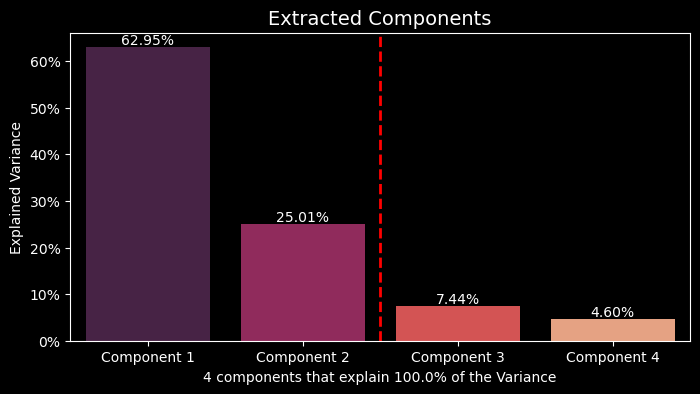

In [21]:
# Accumulated variance graph of the principal components
plt.figure(figsize=(8,4), dpi=100)
ax = sns.barplot(x=eigen_table.index, y='Relative Variance', hue=eigen_table.index, palette='rocket', data=eigen_table)
for container in ax.containers:
    labels = [f"{v*100:.2f}%" for v in container.datavalues]
    ax.bar_label(container, labels=labels)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
ax.axvline(x=1.5, color='red', linestyle='--', linewidth=2)
plt.title("Extracted Components", fontsize=14)
plt.xlabel(f"{eigen_table.shape[0]} components that explain {round(eigen_table['Relative Variance'].sum()*100,2)}% of the Variance", 
           fontsize=10)
plt.ylabel("Explained Variance", fontsize=10)
plt.show()

In [22]:
# Now that we've decided to continue only with the first two components, that accumulate 87.96% of total variance (and thus data
# representation), and now that we also have the eigenvalues and eigenvectors, we may calculate the loadings and communalities of
# each original variable on each component, in order to evaluate, in general, what actual semantics each component explains. For 
# calculating the loadings, we multiply the weight values of each component, that is, its eigenvector values, by the square root 
# of each component's absolute variance, that is, its eigenvalue. If we consider all components, instead of only the most 
# representative ones, we'd have the sum of squares of the loadings of each variable, at each component, being 1, and this would 
# be the communality of the respective variable at each component. In our case, though, as we're selecting only the two first 
# components - the most representatives regarding their eigenvalues - we'll have lower communalities (<1), because some of the 
# variance (and data representativeness) is lost on the components we discarded, and some of the loadings too, and therefore some 
# of the communalities. Nonetheless, the remaining variance, loadings and communalities remained and concentrated on those fewer 
# representative components should suffice to our analytics regarding our dataset on those main components... and it should be 
# much easier (and computable) to do that analysis on two components than, if it was the case, on tens of original variables. We 
# can calculate the loadings and communalities using the methods below:

In [23]:
# calculating and presenting loadings of each original variable on each component
# we can see that Component 1 correlates mostly with FINANCE, ACCOUNTING and ACTUARIAL variables, but not with MARKETING,
# while Component 2 correlates mostly with MARKETING, but basically none with the other variables.
loadings = fa.loadings_
loadings_table = pd.DataFrame(loadings)
loadings_table.columns = [f"C{i+1} loading" for i, v in enumerate(loadings_table.columns)]
loadings_table.index = grades_without_student.columns
print(loadings_table)

            C1 loading  C2 loading  C3 loading  C4 loading
FINANCE       0.895398    0.007086    0.436720    0.086533
ACCOUNTING    0.934033    0.048581   -0.119783   -0.332978
MARKETING    -0.042466    0.998933   -0.000358    0.018170
ACTUARIAL     0.917697   -0.010133   -0.304210    0.255315


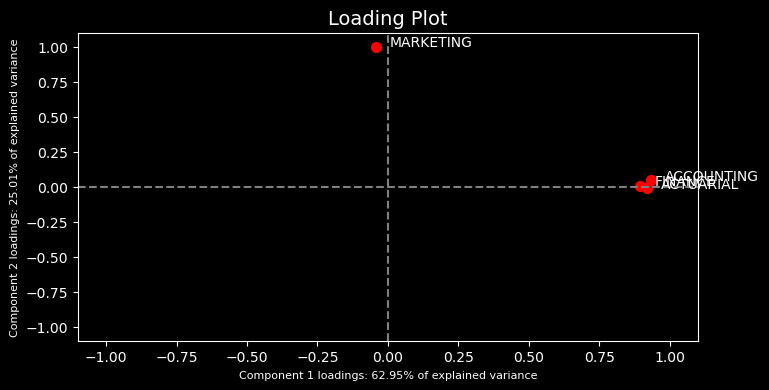

In [24]:
# we can create a loading plot as below, in order to view that on a 2D graph (considered only the 2 first main Components):
plt.figure(figsize=(8,4), dpi=100)
loadings_table_chart = loadings_table.reset_index()
plt.scatter(loadings_table_chart['C1 loading'], loadings_table_chart['C2 loading'], s=50, color='red')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])
label_point(x = loadings_table_chart['C1 loading'],
            y = loadings_table_chart['C2 loading'],
            val = loadings_table_chart['index'],
            ax = plt.gca()) 
plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot", fontsize=14)
plt.xlabel(f"Component 1 loadings: {round(eigen_table.iloc[0]['Relative Variance']*100,2)}% of explained variance", fontsize=8)
plt.ylabel(f"Component 2 loadings: {round(eigen_table.iloc[1]['Relative Variance']*100,2)}% of explained variance", fontsize=8)
plt.show()

In [25]:
# we can see at the 2-component Loading Plot graph above that, at Component 1 axis, the FINANCE, ACCOUNTING and ACTUARIAL loadings
# are close to +1, and MARKETING loading is close to zero, while, at the Component 2 axis, it's the opposite, with the MARKETING
# having loadings close to +1 and loadings close to zero, regarding the other variables. If it is necessary, a rotation on the axes
# can be done here, with a redistribution of the loadings between the axes, in order to turn their interpretation easier - loadings 
# of each variable maximum at one axis and minimum on the other. Here we don't need that, as we already have the maximum of 3 
# variables' loadings at one axis - with zero of them on the other, and the same for the other variable on the other axis. The 
# loadings here are already optimized. This rotation, when necessary - i.e. when you have moderate, instead of extreme, loading 
# values - preserves total variance of retained compoments, as well as the individual component explained variance (eigenvalues - 
# lambda), and thus the relative variance of the components. Communalities also do not change, as the sum of squares of all 
# loadings, for each variable (redistributed throughout all components), remains the same, although the loadings themselves, for 
# individual variables, at each component, are adjusted. As the eigenvectors (axes) change, as the component weight values they 
# represent, the observations' factorial scores also change. Ortogonal correlation of component axes remains zero (although oblique 
# correlation changes). At the end of the day, this loading plot is just to let us see better what we have at the loadings_table 
# above, in order to label and interpret better the meaning of our principal components and the variance of data score they 
# individually explain (or the data they express, correlated with the original variables through the loadings).

In [26]:
# calculating and presenting the communalities:
# Here we calculate for all components, which gives us 1 for all communalities, but below we recalculate only for the two main 
# components we decided to keep, which gives lower but still significant communalities.
communalities = fa.get_communalities()
communalities_table = pd.DataFrame(communalities)
communalities_table.columns = ['Communalities']
communalities_table.index = grades_without_student.columns
print(communalities_table)

            Communalities
FINANCE               1.0
ACCOUNTING            1.0
MARKETING             1.0
ACTUARIAL             1.0


In [27]:
# We should now calculate the factorial score, for each component and observation, which is the product of each weight (optimized 
# coefficient value), respective to each original variable, by each Z score value, i.e., the standardized value of each original 
# variable, at each observation. A big confusion here is regarding the difference between weights and factorial scores. Weights 
# are the coefficients at the score expression of each component. These weights are fixed coefficients for the components, when 
# their expression is set. The factorial scores, on the other hand, are a resulting numerical value for each observation values 
# when the Z score values of their original variables are multiplied by the respective weights. The scores are calculated from 
# sum of products of the weights by the respective Z values. For mounting the component expression, you only need the weights. 
# For calculating the scores, from that expression, for every observation, then you need also the Z values of each original value 
# of each observation. In fact, the FactorAnalyzer lib only calculates the weights when executing the transform() method, so we
# should only try to get the weights, from the fa object, after that (otherwise it will return None weights).

In [28]:
# calculating and showing the 4-component scores for each observation
# (the same as if we calculated it manually, at each component expression, for each observation values)
scores_df = pd.DataFrame(fa.transform(grades_without_student))
scores_df.columns =  [f"C{i+1} SCORE" for i, v in enumerate(scores_df.columns)]
scores_df

,C1 SCORE,C2 SCORE,C3 SCORE,C4 SCORE
0,0.015232,-1.673452,-0.176396,0.743198
1,-1.082468,1.510196,0.344452,-0.829870
2,-0.603231,-0.607015,-0.635247,-0.670994
3,1.352586,0.891321,0.327787,-0.228435
4,-0.984279,-0.926699,0.163203,0.384190
...,...,...,...,...
95,0.121867,-0.169227,1.037620,0.456371
96,1.220881,-0.577316,-0.549185,1.961256
97,0.829146,0.499201,0.735807,0.557208
98,1.186171,-0.918969,-0.304080,1.111389


In [29]:
# adding the scores to the original data df
if not any("SCORE" in col for col in grades.columns):
    grades = pd.concat([grades.reset_index(drop=True), scores_df], axis=1)
grades

,STUDENT,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL,C1 SCORE,C2 SCORE,C3 SCORE,C4 SCORE
0,Gabriela,5.8,4.0,1.0,6.0,0.015232,-1.673452,-0.176396,0.743198
1,Luiz Felipe,3.1,3.0,10.0,2.0,-1.082468,1.510196,0.344452,-0.829870
2,Patrícia,3.1,4.0,4.0,4.0,-0.603231,-0.607015,-0.635247,-0.670994
3,Gustavo,10.0,8.0,8.0,8.0,1.352586,0.891321,0.327787,-0.228435
4,Letícia,3.4,2.0,3.2,3.2,-0.984279,-0.926699,0.163203,0.384190
...,...,...,...,...,...,...,...,...,...
95,Sheila,7.7,4.3,5.2,5.1,0.121867,-0.169227,1.037620,0.456371
96,Pedro,9.0,6.0,4.0,9.8,1.220881,-0.577316,-0.549185,1.961256
97,Horácio,9.3,6.0,7.0,7.0,0.829146,0.499201,0.735807,0.557208
98,Leandro,9.0,6.5,3.0,9.0,1.186171,-0.918969,-0.304080,1.111389


In [30]:
# observe that the correlation between the component scores among themselves is zero - ortogonal
pg.rcorr(grades[['C1 SCORE','C2 SCORE', 'C3 SCORE', 'C4 SCORE']],
         method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,C1 SCORE,C2 SCORE,C3 SCORE,C4 SCORE
C1 SCORE,-,,,
C2 SCORE,0.0,-,,
C3 SCORE,0.0,-0.0,-,
C4 SCORE,0.0,-0.0,-0.0,-


In [31]:
# Now we may check out which adjusted weights have been calculated and what component expressions are for calculating the scores, 
# if we would do it manually. These adjusted computed weights are only calculated, at the FactorAnalyzer lib, after the trnasform() 
# method is called, as above... not before.

# showing factorial adjusted weights (coefficients) of each original variable on each component (observe that these are not the
# same values as the eigenvector values, but a computed vectorial adjustment of these):
weights_df_transposed = get_weights_df().T
weights_df_transposed

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
C1 weight,0.355581,0.370924,-0.016864,0.364436
C2 weight,0.007083,0.048562,0.998554,-0.010129
C3 weight,1.467395,-0.402475,-0.001204,-1.022155
C4 weight,0.470601,-1.810861,0.098814,1.388503


In [32]:
# Having the adjusted weights and the original variables' values (in Z) available, we can now mount the factorial score 
# expression for each component j (considering each variable k), in order to be able to calculate manually - if we wished - the 
# factorial scores, already calculated, by the lib, above (when called the fa transform() method):
for index, row in weights_df_transposed.iterrows():
    print(f"{index[:2]}: ({round(row["FINANCE"],6)})*ZX1i + ({round(row['ACCOUNTING'],6)})*ZX2i + ({round(row['MARKETING'],6)})*ZX3i + ({round(row['ACTUARIAL'],6)})*ZX4i")

C1: (0.355581)*ZX1i + (0.370924)*ZX2i + (-0.016864)*ZX3i + (0.364436)*ZX4i
C2: (0.007083)*ZX1i + (0.048562)*ZX2i + (0.998554)*ZX3i + (-0.010129)*ZX4i
C3: (1.467395)*ZX1i + (-0.402475)*ZX2i + (-0.001204)*ZX3i + (-1.022155)*ZX4i
C4: (0.470601)*ZX1i + (-1.810861)*ZX2i + (0.098814)*ZX3i + (1.388503)*ZX4i


In [33]:
# We have calculated everything about our PCA analysis above, considering all 4 components. Now we just have to recalculate 
# everything, only considering the 2 components we wish to keep (eigenvalue >1), while discarding the other two (eigenvalue <=1).

In [34]:
# recalculating fa for only 2 principal components
fa_2 = FactorAnalyzer(n_factors=2, method='principal', rotation=None).fit(grades_without_student)

In [35]:
# getting the absolute, relative and accumulated variances for the two main components
# (values are the same as with 4 components, showing only the variances of first 2 components)
eigenvalues_variances_2 = fa_2.get_factor_variance()
eigen_table_2 = pd.DataFrame(eigenvalues_variances_2)
eigen_table_2.columns = [f"Component {i+1}" for i, v in enumerate(eigen_table_2.columns)]
eigen_table_2.index = ['Absolute Variance','Relative Variance', 'Accumulated Variance']
eigen_table_2 = eigen_table_2.T
print(eigen_table_2)

             Absolute Variance  Relative Variance  Accumulated Variance
Component 1           2.518127           0.629532              0.629532
Component 2           1.000379           0.250095              0.879627


In [36]:
# getting the loadings for the two main components
# (values are the same as with 4 components, showing only the loadings of first 2 components)
loadings_2 = fa_2.loadings_
loadings_table_2 = pd.DataFrame(loadings_2)
loadings_table_2.columns = [f"C{i+1} loading" for i, v in enumerate(loadings_table_2.columns)]
loadings_table_2.index = grades_without_student.columns
print(loadings_table_2)

            C1 loading  C2 loading
FINANCE       0.895398    0.007086
ACCOUNTING    0.934033    0.048581
MARKETING    -0.042466    0.998933
ACTUARIAL     0.917697   -0.010133


In [37]:
# getting the communalities for the two main components, discarded the other two components
# (values do change, compared to the values with 4 components (all = 1), as there's a loss on variance and loadings from the
# 2 components that have been discarded)
# Observe that, still, we keep > 80% of the original information, considering only the first two main components. If a higher
# communality is desired, for ex., >90%, maybe including the third main component would do... but that will depend on the
# granularity of the variance and loadings distributed throughout the total components. Components with eigenvalues < 0.9, 
# generally, are not worth beingn included
communalities_2 = fa_2.get_communalities()
communalities_table_2 = pd.DataFrame(communalities_2)
communalities_table_2.columns = ['Communalities']
communalities_table_2.index = grades_without_student.columns
print(communalities_table_2)

            Communalities
FINANCE          0.801788
ACCOUNTING       0.874778
MARKETING        0.999670
ACTUARIAL        0.842271


In [38]:
# recalculating the fatorial scores only for the first 2 main components, for each observation
# (values are the same as with 4 components, showing only the scores of first 2 components)
scores_df_2 = pd.DataFrame(fa_2.transform(grades_without_student))
scores_df_2.columns =  [f"C{i+1} SCORE" for i, v in enumerate(scores_df_2.columns)]
scores_df_2

,C1 SCORE,C2 SCORE
0,0.015232,-1.673452
1,-1.082468,1.510196
2,-0.603231,-0.607015
3,1.352586,0.891321
4,-0.984279,-0.926699
...,...,...
95,0.121867,-0.169227
96,1.220881,-0.577316
97,0.829146,0.499201
98,1.186171,-0.918969


In [39]:
# Dropping the previous 4-component scores from the original grades table and adding the 2-component scores just calculated:
# (values are the same as with 4 components, showing only the scores of first 2 components)
# Dropping previous scores...
if any("SCORE" in col for col in grades.columns):
    grades = grades.drop(columns=[col for col in grades.columns if "SCORE" in col])
# Adding new scores...
if not any("SCORE" in col for col in grades.columns):
    grades = pd.concat([grades.reset_index(drop=True), scores_df_2], axis=1)
grades

,STUDENT,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL,C1 SCORE,C2 SCORE
0,Gabriela,5.8,4.0,1.0,6.0,0.015232,-1.673452
1,Luiz Felipe,3.1,3.0,10.0,2.0,-1.082468,1.510196
2,Patrícia,3.1,4.0,4.0,4.0,-0.603231,-0.607015
3,Gustavo,10.0,8.0,8.0,8.0,1.352586,0.891321
4,Letícia,3.4,2.0,3.2,3.2,-0.984279,-0.926699
...,...,...,...,...,...,...,...
95,Sheila,7.7,4.3,5.2,5.1,0.121867,-0.169227
96,Pedro,9.0,6.0,4.0,9.8,1.220881,-0.577316
97,Horácio,9.3,6.0,7.0,7.0,0.829146,0.499201
98,Leandro,9.0,6.5,3.0,9.0,1.186171,-0.918969


In [40]:
# getting the adjusted weights from the 2-component fa (transform method has already been called, so the weights have been already
# calculated)
# (values are the same as with 4 components, showing only the adjusted weights for the first 2 components)
weights_2 = fa_2.weights_
weights_df_2 = pd.DataFrame(weights_2)
weights_df_2.columns = [f"C{i+1} weight" for i, v in enumerate(weights_df_2.columns)]
weights_df_2.index = grades_without_student.columns
weights_df_2_transposed = weights_df_2.T
weights_df_2_transposed

,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL
C1 weight,0.355581,0.370924,-0.016864,0.364436
C2 weight,0.007083,0.048562,0.998554,-0.010129


In [41]:
# mounting the factorial score expression for each component j (considering each variable k), in order to be able to calculate 
# manually - if we wished - the factorial scores, already calculated, by the lib, above (when called the fa transform() method).
# (expressions are the same as with 4 components, showing only the expressions first 2 components)
for index, row in weights_df_2_transposed.iterrows():
    print(f"{index[:2]}: ({round(row["FINANCE"],6)})*ZX1i + ({round(row['ACCOUNTING'],6)})*ZX2i + ({round(row['MARKETING'],6)})*ZX3i + ({round(row['ACTUARIAL'],6)})*ZX4i")

C1: (0.355581)*ZX1i + (0.370924)*ZX2i + (-0.016864)*ZX3i + (0.364436)*ZX4i
C2: (0.007083)*ZX1i + (0.048562)*ZX2i + (0.998554)*ZX3i + (-0.010129)*ZX4i


In [42]:
# Our ultimate goal here, at this project, is to use a weighted sum for sorting and ranking all observations (best students rank)
# The ranking will consider only the 2 components we selected (with eigenvalues > 1), not the original variables directly
# When using PCA with Factorial Analysis, we should use factorial scores for ranking observations, with or without weighting it
# with the relative variance of each component, when computing the summation of that observation total rank value
# So, for every observation (line of students grades table), we sum the products of each component factorial score by the relative
# variance (relative eigenvalue) of each respective component, totaling the weighted factorial scores for the main components, for 
# each observation. The results are the values to be ranked when ordered in descending order. 

# In this use case, the best student is the one with the highest "RANKING" value (1.619616), i.e., student 28 (Adelino), while the worst 
# student is the one with the lowest "RANKING" value (-1.292025), i.e., student 50 (Gilmar).

grades['RANKING'] = 0

score_column_names = ["C1 SCORE", "C2 SCORE"]
relative_variance_c1 = eigen_table_2.loc["Component 1"]["Relative Variance"]
relative_variance_c2 = eigen_table_2.loc["Component 2"]["Relative Variance"]

for i in range(0,grades.index.size):
    c1_score_value = grades.loc[i][score_column_names[0]]
    c2_score_value = grades.loc[i][score_column_names[1]]
    grades.at[i, 'RANKING'] = c1_score_value*relative_variance_c1+c2_score_value*relative_variance_c2
grades.sort_values(by="RANKING", ascending=False)


,STUDENT,FINANCE,ACCOUNTING,MARKETING,ACTUARIAL,C1 SCORE,C2 SCORE,RANKING
28,Adelino,9.9,10.0,10.0,10.0,1.924226,1.632397,1.619616
11,Renata,7.7,10.0,10.0,10.0,1.672455,1.627382,1.459863
18,Cecília,9.8,10.0,7.0,10.0,1.930760,0.567678,1.357448
15,Felipe,8.7,10.0,9.0,9.0,1.647143,1.278882,1.356770
14,Giulia,6.2,10.0,10.0,10.0,1.500793,1.623962,1.350941
...,...,...,...,...,...,...,...,...
54,Ester,0.6,1.9,3.0,3.2,-1.318695,-1.006035,-1.081765
29,Carolina,3.1,2.0,2.0,2.0,-1.186316,-1.348318,-1.084031
20,Elaine,3.1,2.0,2.0,2.0,-1.186316,-1.348318,-1.084031
56,Viviane,0.7,1.9,2.8,2.8,-1.364351,-1.075153,-1.127793


In [43]:
# Of course, this is a very simple use case, just to explain the whole process and all attributes involved in the Factorial Analysis by
# Principal Components. This technique is exactly the same when applied to more complex use case scenarios, though, as real estate price 
# analysis, credit risk analysis, health risk analysis, demographic and socioeconomic analysis, geospatial analysis of more developed 
# cities or countries, military defense analysis, psycological analysis - with latent components not easily perceived on original 
# variables, etc. 
# After calculating the factorial scores, we can just work with them on our analytics of the problem, relating the dataset to the original 
# variables (indirectly), but using the few principal components instead (2 or 3). This is extremely useful when you have a scenario with 
# tens or hundreds of original variables, and you wish to reduce that dimensionality into 2 or 3 principal components, instead. The 
# factorial scores, for each observation of the dataset, for each component, can then be analyzed and the observations ranked. Other than 
# that, you can, in fact, use PCA for preparing your data for later use with other ML analyses, as Clustering Analysis or Regression 
# Analysis, as mentioned on the introduction of this project.